In [32]:
# Librerías de Base
import warnings
warnings.filterwarnings('ignore')

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [34]:
# Librerías para uso estadístico y de series de tiempo
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA


In [35]:
# Se analizaran las series de tiempo de Amazon
df_amazon = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

In [36]:
df_amazon['Close'].shape

(3019,)

### Serie Reversión a la Media

In [37]:
def mod_vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):
    np.random.seed(seed)
    dt = T / float(N)
    rates = [r0]
    for i in range(N):
        dr = K * (theta - rates[-1]) * dt + sigma * np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N + 1), rates

In [38]:
# Parámetros estimados
r0 = df_amazon['Close'].iloc[0]  # Usar el primer retorno logarítmico como valor inicial
K = 0.2  # Tasa de reversión a la media
theta = df_amazon['Close'].mean()  # Media a largo plazo
sigma = df_amazon['Close'].std()  # Volatilidad
T = 0 #Inicio
N = 3000  #Fin
seed = np.random.randint(100, 900)

x, y = mod_vasicek(r0, K, theta, sigma, T, N, seed)


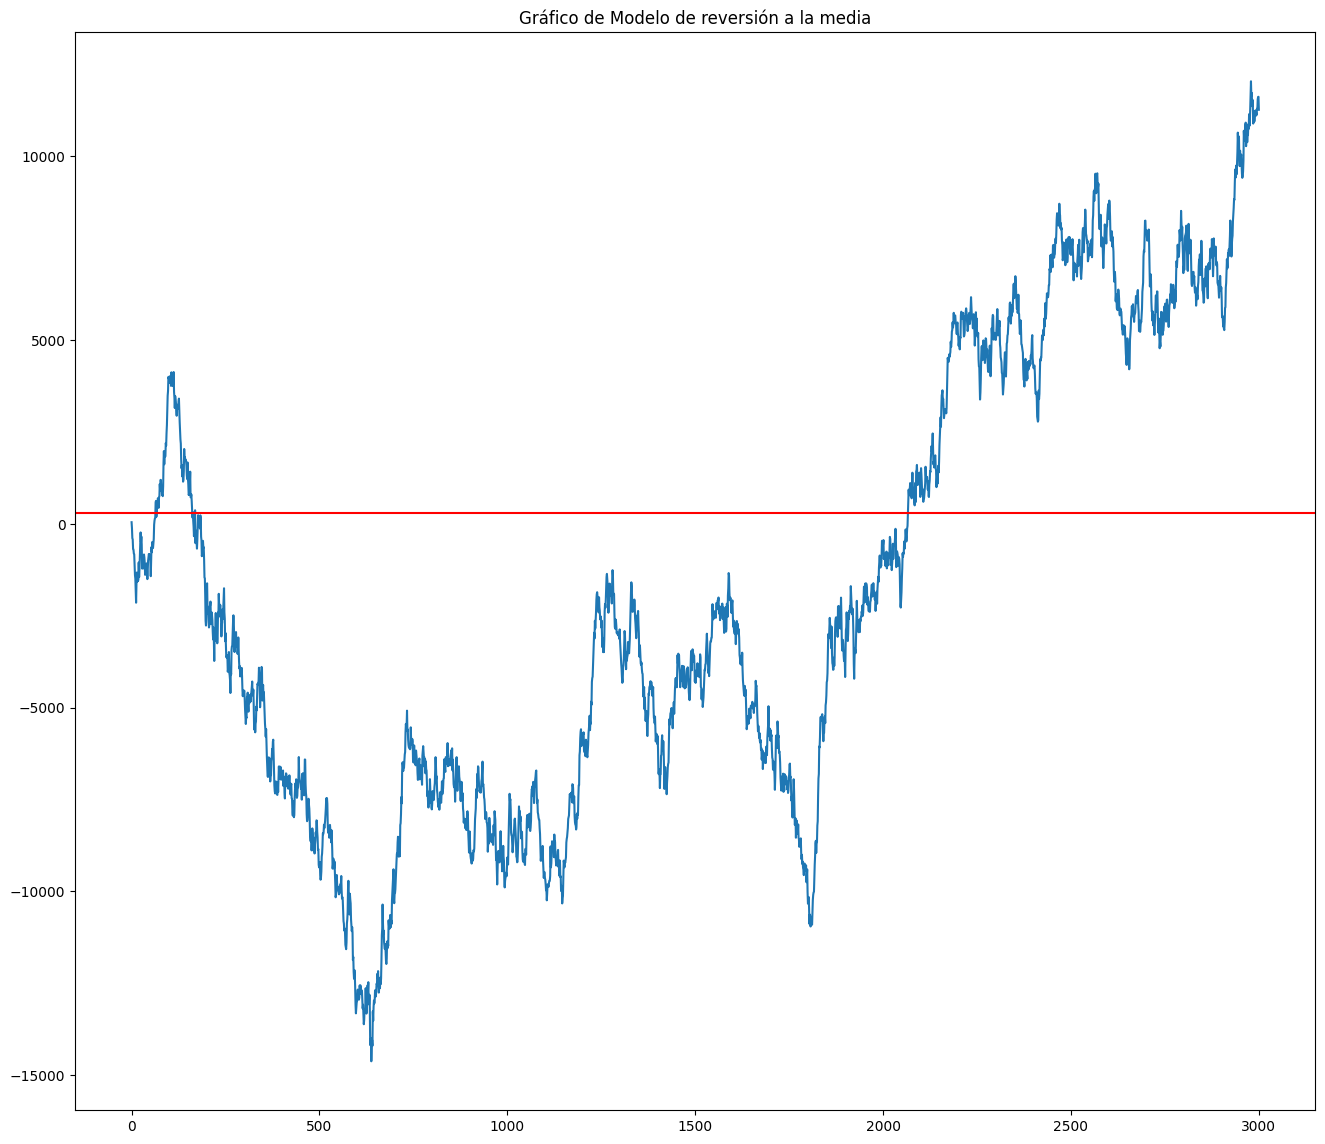

In [39]:
# Generación de gráfica del modelo de Reversión a la media
plt.plot(x,y)
plt.title('Gráfico de Modelo de reversión a la media')
plt.axhline(theta, color='red')
plt.show()


## Movimiento Browniano.

In [40]:
# Parámetros del Movimiento Browniano
delta = 0.25
dt = 1 / len(df_amazon) #por dia
xini = df_amazon['Close'].iloc[0]
ntra = 10  # Número de trayectorias
n = len(df_amazon)  # Número de iteraciones (días)

In [41]:
# Genera las trayectorias en un DataFrame (dfres)
res = []
dfres = pd.DataFrame().assign(traj=0, nsample=0, sample=0)

for i in range(ntra+1):
    x = xini  # Iniciar cada trayectoria desde el precio inicial
    for k in range(1, n + 1):
        x = x + norm.rvs(scale=delta**2*dt)  # usar sqrt(dt) para el escalamiento correcto
        df2 = pd.DataFrame({'traj': [i], 'nsample': [k], 'sample': [x]})
        dfres = pd.concat([dfres, df2], ignore_index=True)


In [42]:
# Genera los puntos iniciales
for i in range(ntra+1):
    df2 = pd.DataFrame({'traj': [i], 'nsample': [0], 'sample': [xini]})
    dfres = pd.concat([dfres, df2], ignore_index=True)

<Axes: xlabel='nsample', ylabel='sample'>

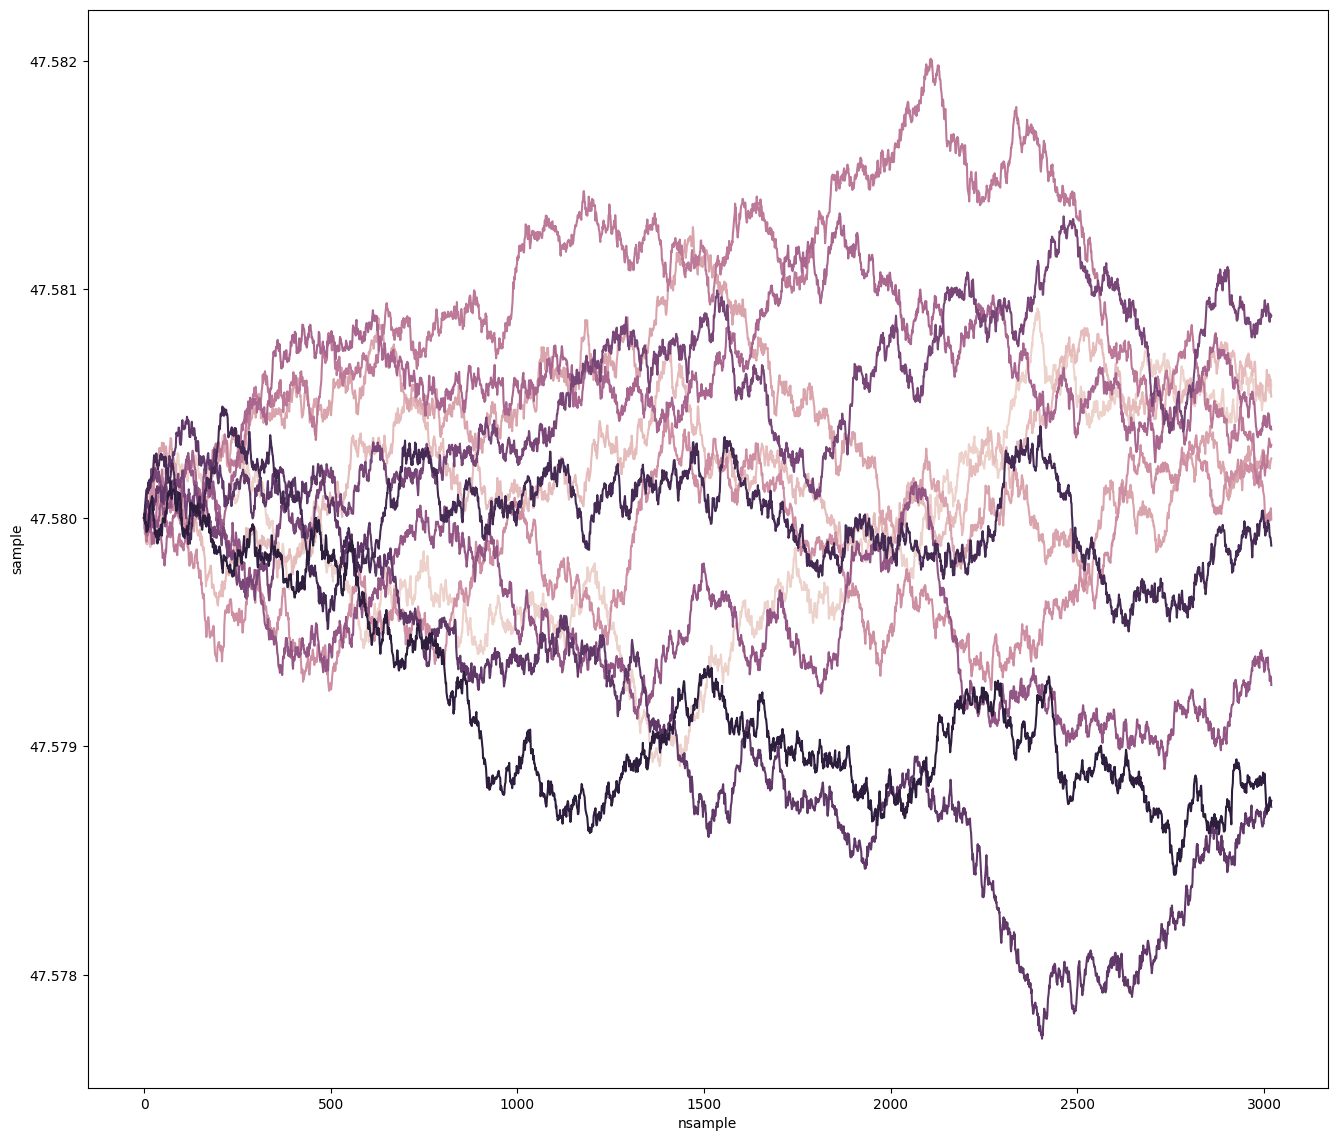

In [43]:
# Plot de las muestras

sns.lineplot(data=dfres, x='nsample', y='sample', legend=None, ci=None, hue='traj')

In [44]:
# Se pueden obtener las trayectorias
pd.pivot_table(dfres, index=['traj'], columns=['nsample'])

sample                                                         \
nsample   0          1          2          3          4          5      
traj                                                                    
0        47.58  47.580019  47.580023  47.580019  47.580027  47.580027   
1        47.58  47.579974  47.579930  47.579933  47.579928  47.579896   
2        47.58  47.579992  47.579989  47.579986  47.580027  47.580026   
3        47.58  47.579993  47.579954  47.579958  47.579955  47.579945   
4        47.58  47.580006  47.579952  47.579972  47.579930  47.579929   
5        47.58  47.580020  47.580012  47.579967  47.579954  47.579931   
6        47.58  47.579996  47.580028  47.580055  47.580036  47.580043   
7        47.58  47.579994  47.580010  47.580032  47.580022  47.580053   
8        47.58  47.579987  47.580002  47.580003  47.580030  47.580024   
9        47.58  47.580005  47.580026  47.580057  47.580074  47.580095   
10       47.58  47.580003  47.580019  47.579991  47.579973  47.579982   

                                                     ...             \
nsample       6          7          8          9     ...       3010   
traj                                                 ...              
0        47.579987  47.579987  47.579983  47.579988  ...  47.580562   
1        47.579887  47.579894  47.579896  47.579883  ...  47.580577   
2        47.580008  47.580002  47.580016  47.580030  ...  47.580239   
3        47.579953  47.579934  47.579954  47.579976  ...  47.579984   
4        47.579902  47.579895  47.579935  47.579939  ...  47.580283   
5        47.579924  47.579948  47.579937  47.579922  ...  47.580443   
6        47.579992  47.579976  47.580009  47.580016  ...  47.579390   
7        47.580057  47.580084  47.580073  47.580120  ...  47.580937   
8        47.580051  47.580043  47.580067  47.580061  ...  47.578733   
9        47.580119  47.580124  47.580124  47.580130  ...  47.579989   
10       47.579952  47.579939  47.579949  47.579950  ...  47.578716   

                                                                           \
nsample       3011       3012       3013       3014       3015       3016   
traj                                                                        
0        47.580574  47.580554  47.580576  47.580548  47.580568  47.580581   
1        47.580605  47.580620  47.580627  47.580623  47.580617  47.580587   
2        47.580251  47.580221  47.580245  47.580227  47.580216  47.580238   
3        47.579975  47.579993  47.580024  47.580010  47.579987  47.580011   
4        47.580312  47.580319  47.580348  47.580341  47.580333  47.580324   
5        47.580459  47.580442  47.580449  47.580427  47.580395  47.580392   
6        47.579337  47.579338  47.579330  47.579317  47.579286  47.579304   
7        47.580924  47.580901  47.580864  47.580873  47.580858  47.580895   
8        47.578746  47.578720  47.578742  47.578756  47.578742  47.578754   
9        47.579962  47.579975  47.579970  47.579939  47.579917  47.579916   
10       47.578723  47.578743  47.578737  47.578771  47.578778  47.578770   

                                          
nsample       3017       3018       3019  
traj                                      
0        47.580578  47.580606  47.580576  
1        47.580576  47.580549  47.580531  
2        47.580242  47.580260  47.580260  
3        47.580035  47.580043  47.579993  
4        47.580310  47.580311  47.580320  
5        47.580403  47.580391  47.580387  
6        47.579307  47.579303  47.579269  
7        47.580877  47.580883  47.580885  
8        47.578739  47.578739  47.578735  
9        47.579913  47.579894  47.579879  
10       47.578742  47.578756  47.578762  

[11 rows x 3020 columns]

## Modelo autorregresivo

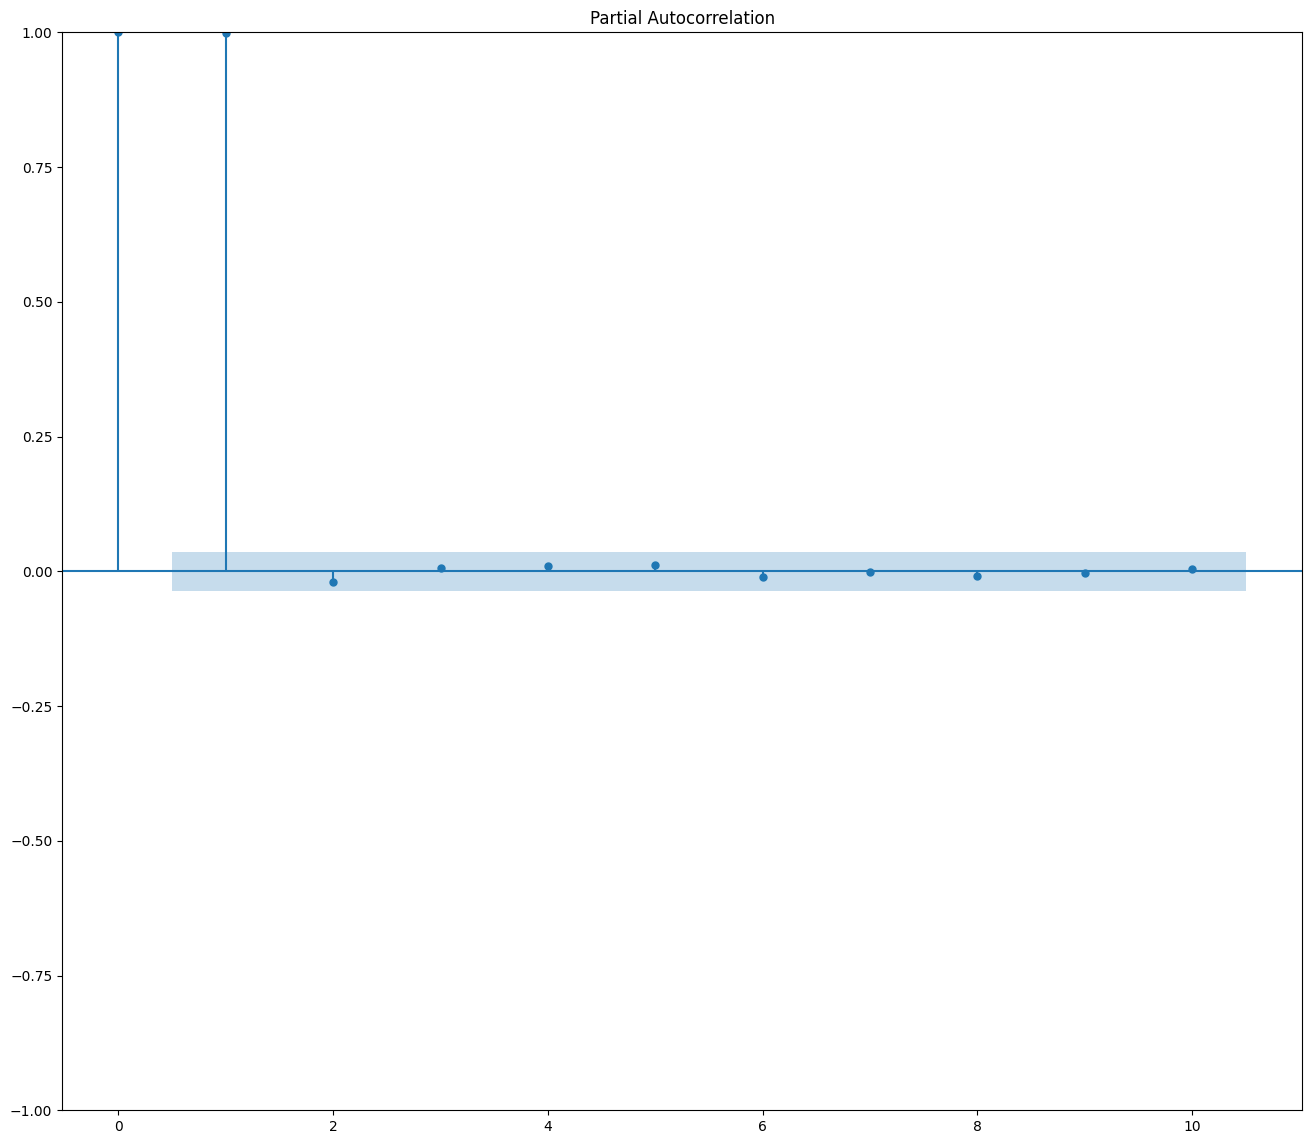

In [50]:
# Ajustar el modelo AR
plot_pacf(df_amazon['Close'], lags=10)
plt.show()

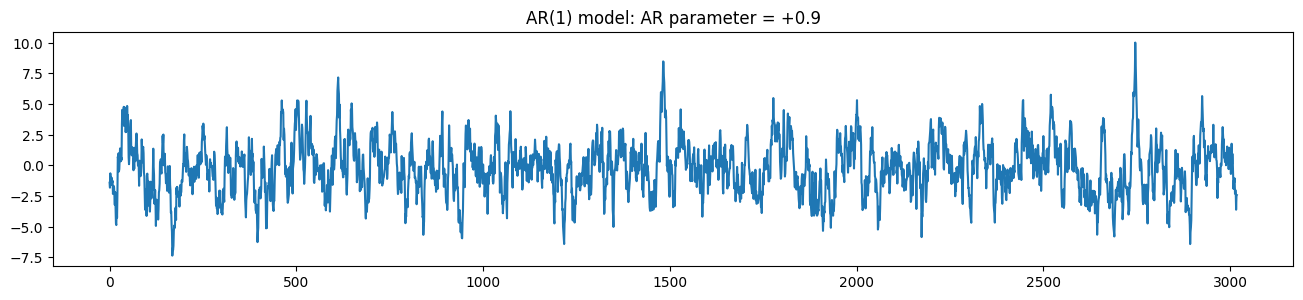

In [46]:
from pylab import rcParams
# Generación de la Serie de Tiempo AR
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 14
plt.subplot(4,1,1)

#Se especifican los parámetros de AR y MA (AR -0.9)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=len(df_amazon))
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)



In [47]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(sim1, order=(1,0,0))
result = model.fit()

In [48]:
print("miu={}, theta={}".format(result.params[0], result.params[1]))
print(result.summary())

miu=-0.21496242106902066, theta=0.8869069079443249
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3019
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4276.383
Date:                Tue, 06 Aug 2024   AIC                           8558.766
Time:                        00:24:44   BIC                           8576.804
Sample:                             0   HQIC                          8565.252
                               - 3019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2150      0.161     -1.339      0.181      -0.530       0.100
ar.L1          0.8869      0.008    108.515      0.000       0.871       0.903
s

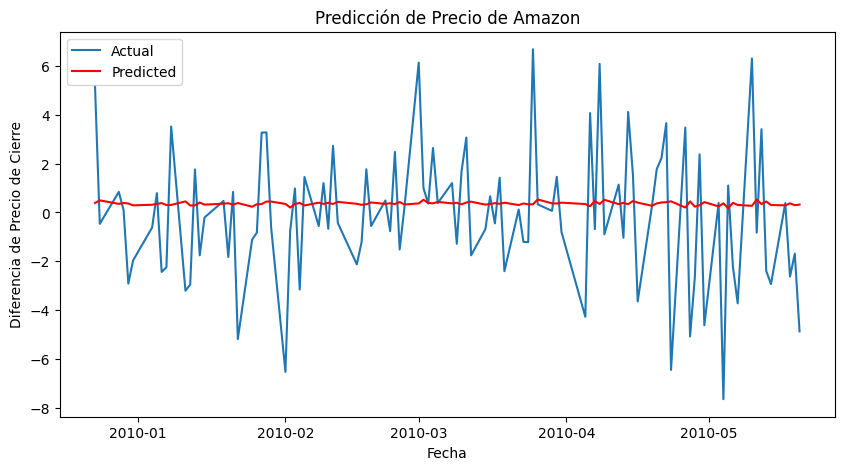

In [52]:
# Diferenciar los datos para hacerlos estacionarios
amazon_price_diff = df_amazon['Close'].diff().dropna()

# Ajustar el modelo ARIMA
amazon_price_model = ARIMA(amazon_price_diff, order=(1, 0, 0))
res = amazon_price_model.fit()

# Realizar predicciones
pred_start = 1000
pred_end = 1100
predictions = res.predict(start=pred_start, end=pred_end)

plt.figure(figsize=(10, 5))
plt.plot(amazon_price_diff.index[pred_start:pred_end+1], amazon_price_diff[pred_start:pred_end+1], label='Actual')
plt.plot(amazon_price_diff.index[pred_start:pred_end+1], predictions, label='Predicted', color='red')
plt.title('Predicción de Precio de Amazon')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de Precio de Cierre')
plt.legend()
plt.show()

In [53]:
# Diferencia la serie temporal y elimina los valores NaN
diff_high = df_amazon['High'].diff().dropna()

# Generar predicciones
start = 900
end = 999
predictions = res.predict(start=start, end=end)
observed_values = diff_high.iloc[start:end + 1].values
predictions = predictions[:len(observed_values)]
# Calcular RMSE
rmse = math.sqrt(mean_squared_error(observed_values, predictions))
print('RMSE = {}.'.format(rmse))

RMSE = 3.1959469670081604.


## Moving Average

In [ ]:
# Lo que se van a predecir son las variaciones absolutas
df_amazon['Close'].diff().iloc[1:].values

array([ -0.33,   0.4 ,   0.22, ...,   5.5 ,   3.84, -16.63])

In [ ]:
model = ARIMA(df_amazon['Close'].diff().iloc[1:], order=(0, 0, 3))
result = model.fit()

c:\Users\Bodok\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Bodok\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Bodok\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
print("miu={}, theta={}".format(result.params[0], result.params[1]))
print(result.summary())

miu=0.3718037658768365, theta=0.02086436989024196
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3018
Model:                 ARIMA(0, 0, 3)   Log Likelihood              -10055.845
Date:                Mon, 05 Aug 2024   AIC                          20121.690
Time:                        16:37:08   BIC                          20151.752
Sample:                             0   HQIC                         20132.500
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3718      0.128      2.907      0.004       0.121       0.622
ma.L1          0.0209      0.010      2.045      0.041       0.001       0.041
ma

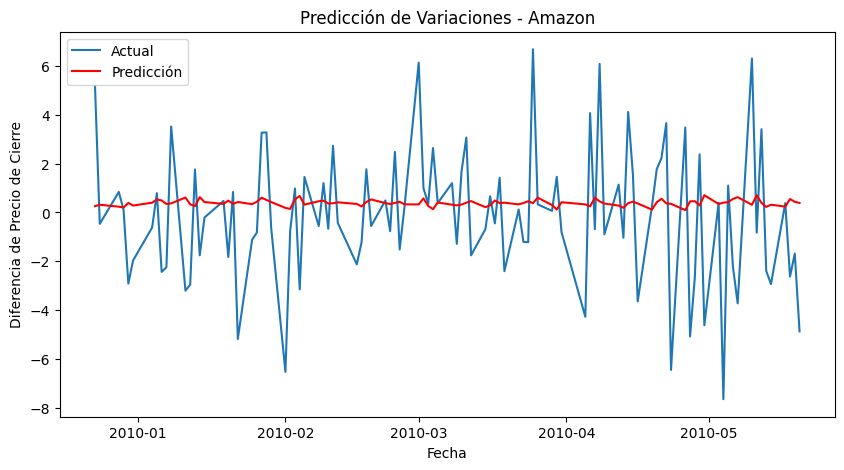

In [ ]:
# Realizar predicciones
pred_start = 1000
pred_end = 1100
predictions = result.predict(start=pred_start, end=pred_end)

plt.figure(figsize=(10, 5))
plt.plot(amazon_price_diff.index[pred_start:pred_end+1], amazon_price_diff[pred_start:pred_end+1], label='Actual')
plt.plot(amazon_price_diff.index[pred_start:pred_end+1], predictions, label='Predicción', color='red')
plt.title('Predicción de Variaciones - Amazon')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de Precio de Cierre')
plt.legend()
plt.show()

In [ ]:
# Diferencia la serie temporal y elimina los valores NaN
diff_high = df_amazon['High'].diff().dropna()

# Generar predicciones
start = 900
end = 999
predictions = res.predict(start=start, end=end)
observed_values = diff_high.iloc[start:end + 1].values
predictions = predictions[:len(observed_values)]
# Calcular RMSE
rmse = math.sqrt(mean_squared_error(observed_values, predictions))
print('RMSE = {}.'.format(rmse))

RMSE = 3.1959469670081604.
